
# NLP: Predicciendo la polaridad de reseñas usando Deep Learning

La importancia de la satisfacción del cliente radica en que nos ayuda a saber la probabilidad de que un cliente haga una compra a futuro. Pedir a los clientes que califiquen el grado de satisfacción es una buena forma de ver si se convertirán en clientes habituales o incluso en defensores de la marca.

En el presente proyecto interameos mejorar el accuracy obtenido en el proyecto anterior, en l que se probaorn algunas tecnica de machine learning tradicional. Sin embargo, la bibliografía apunta a que algunas arquitecturas de redes neuronales funcionan muy bien para procesamiento de lenguaje natural. Por tanto se plantea la siguiente hipotesis: ¿Utilizar un red neuronal de arquitecura LSTM mejorará el accuracy frente a un modelo de Linear SVC para los datos actuales?

El proyecto anterior se puede encontrar aquí: [GitHub Repository](https://github.com/dewith/amazon-ratings)

<div class="alert alert-warning">
<b>The Multilingual Amazon Reviews Corpus</b> <br>
Se puede acceder al dataset <a href="https://drive.google.com/uc?export=download&id=11XnXB7Ubgf3t6gotXGlM4FCwPOMHhDLX">aquí</a>. Es un comprimido .zip que contiene tres archivos .json. Más información sobre el dataset <a href="https://registry.opendata.aws/amazon-reviews-ml/">aquí</a>. Es importante que tengas en cuenta la <a href="https://docs.opendata.aws/amazon-reviews-ml/license.txt">licencia</a> de este dataset.
</div>

## 1. Preprocesado
### 1.1 Importaciones y configuración 

Importamos las librerías necesarias

In [1]:
''' Data manipulation '''
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack

''' Visualization '''
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

''' NLP '''
import re
import nltk

''' Machine Learning '''
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

'''Deep Learning '''
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras.utils import plot_model
from plot_keras_history import plot_history

''' Misc '''
import sys, os, re, csv, codecs, gc
from time import time

Configuramos el estilo de los gráficos

In [2]:
from matplotlib.colors import LinearSegmentedColormap

# Palette
blue = '#146EF5'
red = '#ED3767'
amber = '#F5B14C'
mint = '#17BED1'
purple = '#815ADB'
pink = '#FE90AD'
palette = [blue, red, pink, purple, amber, mint]

# Sequential colormap

redpink = LinearSegmentedColormap.from_list("myReds", ['white', pink, red])
redwhite = LinearSegmentedColormap.from_list("myReds", ['white', red])
bluewhite = LinearSegmentedColormap.from_list("myReds", ['white', blue])


params = {'axes.edgecolor': '0.9', 'axes.labelcolor': '0.4',
          'text.color': '0.3', 'xtick.color': '0.5', 'ytick.color': '0.5',
          'font.size': 16, 'axes.titlesize': 16, 'axes.labelsize': 12,
          'xtick.labelsize': 12, 'ytick.labelsize': 12,
          'figure.figsize': (9, 6), 'axes.spines.right': False, 'axes.spines.top': False}

sns.set(context='notebook', style='white', palette=palette, rc=params)

### 1.2 Carga de datos y preprocesamiento

Cargamos los datos

In [3]:
train = pd.read_csv('/content/train.csv')
dev = pd.read_csv('/content/dev.csv')
test = pd.read_csv('/content/test.csv')

In [4]:
X_train = train[['full_text', 'clean_text']].copy()
X_dev = dev[['full_text', 'clean_text']].copy()
X_test = test[['full_text', 'clean_text']].copy()

In [5]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=100, dtype=np.float32)

train_ngrams =  vectorizer.fit_transform(X_train['clean_text'])
dev_ngrams = vectorizer.transform(X_dev['clean_text'])
test_ngrams = vectorizer.transform(X_test['clean_text'])

# Obtenemos los nombres de las features
features_ngrams = np.array(vectorizer.get_feature_names())

Ahora extraemos las features indirectas:
mean_word_len,
count_stopwords,
word_unique_percent,
count_word, count_letters,
count_unique_word.

In [6]:
try:
  stopword_list = nltk.corpus.stopwords.words('spanish')
except:
  nltk.download('stopwords')
  stopword_list = nltk.corpus.stopwords.words('spanish')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
train_indirect = pd.DataFrame()
train_indirect['count_word'] = X_train['full_text'].apply(lambda x: len(str(x).split()))
train_indirect['count_letters'] = X_train['full_text'].apply(lambda x: len(str(x)))
train_indirect['count_unique_word'] = X_train['full_text'].apply(lambda x: len(set(str(x).split())))
train_indirect["count_stopwords"] = X_train["full_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stopword_list]))
train_indirect["mean_word_len"] = X_train["full_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
train_indirect['word_unique_percent'] = train_indirect['count_unique_word']*100/train_indirect['count_word']

In [8]:
dev_indirect = pd.DataFrame()
dev_indirect['count_word'] = X_dev['full_text'].apply(lambda x: len(str(x).split()))
dev_indirect['count_letters'] = X_dev['full_text'].apply(lambda x: len(str(x)))
dev_indirect['count_unique_word'] = X_dev['full_text'].apply(lambda x: len(set(str(x).split())))
dev_indirect["count_stopwords"] = X_dev["full_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stopword_list]))
dev_indirect["mean_word_len"] = X_dev["full_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
dev_indirect['word_unique_percent'] = dev_indirect['count_unique_word']*100/dev_indirect['count_word']

In [9]:
test_indirect = pd.DataFrame()
test_indirect['count_word'] = X_test['full_text'].apply(lambda x: len(str(x).split()))
test_indirect['count_letters'] = X_test['full_text'].apply(lambda x: len(str(x)))
test_indirect['count_unique_word'] = X_test['full_text'].apply(lambda x: len(set(str(x).split())))
test_indirect["count_stopwords"] = X_test["full_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stopword_list]))
test_indirect["mean_word_len"] = X_test["full_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_indirect['word_unique_percent'] = test_indirect['count_unique_word']*100/test_indirect['count_word']

Leemos los datasets de polaridad

In [10]:
train_polarity = pd.read_csv('/content/train_polarity.csv')
dev_polarity = pd.read_csv('/content/dev_polarity.csv')
test_polarity = pd.read_csv('/content/test_polarity.csv')

Solo falta juntar todas las features en un matriz dispersa

In [11]:
X_train = hstack((train_ngrams, train_indirect,  train_polarity)).tocsr()
X_dev = hstack((dev_ngrams, dev_indirect,  dev_polarity)).tocsr()
X_test = hstack((test_ngrams, test_indirect,  test_polarity)).tocsr()

## 2. Modelado 
El proyecto pasado explicamos que el problema requiere ser abordado como una tarea de clasificación binaria puesto que los datos no permiten obtener una gran exactitud al predecir 5 clases.
Por ello, ahora trataremos de mejorar el accuracy obtenido con Linear SVC (0.86 en el set de validación) con un arquitectura de redes neuronales.

### 2.1 Linear SVC (benchmark)
Predecimos manteniendo solo 2 clases: negativo y postivo (convirtiendo las reviews con 3 estrellas en _negativo_)

In [12]:
def binarize(x):
    if x == 4 or x == 5:
        return 1
    else:
        return 0
    
y_train = train['stars'].apply(binarize)
y_dev = dev['stars'].apply(binarize)
y_test = test['stars'].apply(binarize)

In [13]:
svc = LinearSVC(penalty='l2', dual=False, tol=1e-4, C=0.01)

svc.fit(X_train, y_train)

y_train_pred_svc = svc.predict(X_train)
y_dev_pred_svc = svc.predict(X_dev)
y_test_pred_svc = svc.predict(X_test)

print('Accuracy en el set de Train:', accuracy_score(y_train, y_train_pred_svc))
print('Accuracy en el set de Dev:', accuracy_score(y_dev, y_dev_pred_svc))
print('Accuracy en el set de Test:', accuracy_score(y_test, y_test_pred_svc), '<---')

Accuracy en el set de Train: 0.869985
Accuracy en el set de Dev: 0.869
Accuracy en el set de Test: 0.8646 <---


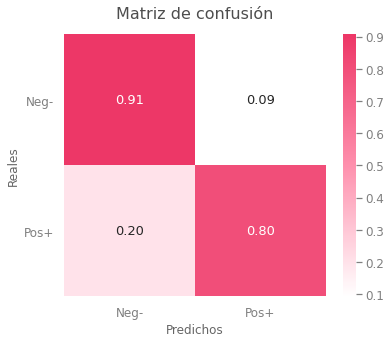

In [14]:
plt.figure(figsize=(6, 5))
conf_sent = confusion_matrix(y_test, y_test_pred_svc, 
                             labels=[0, 1], 
                             normalize='true')
sns.heatmap(data = conf_sent, cbar=True, square=True, annot=True, 
            fmt= '.2f', annot_kws={'size': 13}, 
            xticklabels= ['Neg-', 'Pos+'], 
            yticklabels=['Neg-', 'Pos+'], 
            cmap=redpink)

plt.title('Matriz de confusión', pad=16)
plt.ylabel('Reales')
plt.xlabel('Predichos')
plt.xticks(rotation = 0)
plt.yticks(rotation = 0)
plt.tight_layout()
plt.show()

#### 2.1.2 Neural Network

El enfoque que utilizaremos será crear una red neuronal usando la arquitecura LSTM, la que alimentaremos usando el texto limpio que ya
prepocesamos en el notebook del proyecto anterior.

In [15]:
# Extraemos la lista de los comentarios para cada set
list_sentences_train = train['clean_text']
list_sentences_dev = dev['clean_text']
list_sentences_test = test['clean_text']

In [16]:
#d={1:'Neg', 2:'Neg', 3: 'Neg', 4:'Pos', 5:'Pos'}
#y_train = pd.get_dummies(train['stars'].apply(lambda x:d[x]))
#y_dev = pd.get_dummies(dev['stars'].apply(lambda x:d[x]))
#y_test = pd.get_dummies(test['stars'].apply(lambda x:d[x]))

Para transformar el corpus en números que la red pueda entender haremos esto: lo que vamos a hacer:

1. **Tokenización:** Necesitamos descomponer la frase en palabras únicas.
2. **Indexación:** Ponemos las palabras en una estructura similar a un diccionario y les damos un índice a cada una.
3. **Representación del índice:** Representamos la secuencia de palabras en los comentarios en forma de índice, y alimentar esta cadena de índices en nuestro LSTM.

In [17]:
# Definimos el número máximo de features como 5000 porque fue la cantidad con mejores resultados
max_features = 5000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))

list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_dev = tokenizer.texts_to_sequences(list_sentences_dev)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

Ahora visualizaremos la distribución de la longitud de los comentarios para poder definir una logitud máxima adecuada.

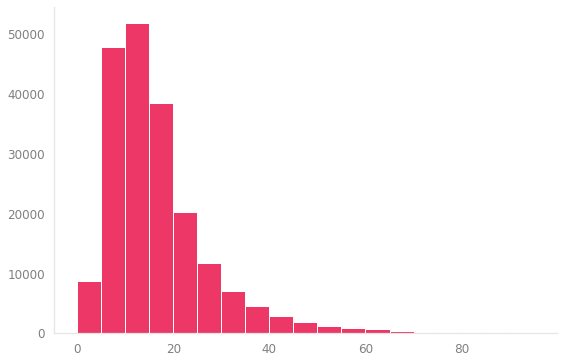

In [18]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]
plt.hist(totalNumWords, bins=np.arange(0,100,5), color=red)
plt.show()

Podemos observar que la mayoría de las reviews tiene menos de 60 tokens, así que podemos este número para tener un rago confiable y que no pierda información . 

In [20]:
maxlen = 60
X_tr = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_de = pad_sequences(list_tokenized_dev, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

**Ahora empezamos a construir el modelo**

Esta es la arquitectura del modelo que estamos tratando de construir.

![](https://i.imgur.com/aZzxWpA.png)


Definimos el capa input con el número máximos de dimensiones que definimos antes

In [21]:
inp = Input(shape=(maxlen, )) #Dejamos el espacio en blanco despues de la coma para que Keras lo infiera

En nuestra capa de embedding 

In [22]:
embed_size = 120
x = Embedding(max_features, embed_size)(inp)

A continuación alimentamos este Tensor a la capa del LSTM. Las arquitecturas basadas en redes neuronales 
recurrentes funcionan alimentando recursivamente el output de una red anterior en la entrada de la red actual, 
y tomarías la salida final después de X número de recursividad. 
Pero dependiendo del caso, se podría querer tomar las salidas de cada recursividad como resultado 
para pasar a la siguiente capa, como en este caso.

La capa de embedding nos proporciona un tensor 3D de (-, 50, 100) que usaremos dentro de la capa de LSTM. 
Que lo que hará será pasar a través de las muestras, ejecutar recursivamente el modelo LSTM durante 50 veces, 
pasando las coordenadas de las palabras cada vez. Y como queremos la versión desenrollada, 
recibiremos una tensor de shape (None, 50, 60), donde 60 es el número de secuencias que correra la capa de LSTM.

In [23]:
x = LSTM(50, return_sequences=True, name='lstm_layer')(x)

Antes de que podamos pasar el output a una capa normal, necesitamos convertir el tensor 3D en uno 2D. 
Por lo tanto, usamos una capa de Global Max Pooling que normalmente se usa en problemas CNN para 
reducir la dimensionalidad de imagenes. Esta capa revisará cada pieza de datos, y
tomará los valores máximos de cada una. Y será esta colección de valores máximos nuestro
conjunto de datos que utilizares en las capas siguientes.

In [24]:
x = GlobalMaxPool1D()(x)

Este Tensor 2D generado lo pasamos a una capa de Dropout que deshabilita arbitrariamente algunos nodos 
para que toda la red pueda resultar en una mejor generalización.

Configuramos un droput del 15%.

In [25]:
x = Dropout(0.15)(x)

Después de una capa de dropout conectamos una capa densamente conectada y la salida pasa a través de 
una función RELU. Hemos definido la capa densa para producir una dimensión de salida de 50.

In [26]:
x = Dense(10, activation="relu")(x)

Añadimos otra capa de dropout

In [27]:
x = Dropout(0.15)(x)

Y, finalmente, el output los generará una capa con activación sigmoide para lograr una clasificación 
binaria(1,0) para cada una de las 2 etiquetas.

In [28]:
x = Dense(1, activation="sigmoid")(x)

Solo queda definir las entradas, salidas y configurar el proceso de aprendizaje de la red. 
Hemos establecido nuestro modelo para optimizar nuestra función de pérdida usando 
el optimizador Adam, definiendo la función de pérdida como "binary_crossentropy" ya 
que estamos abordando una clasificación binaria.

In [30]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                        optimizer='sgd',
                        metrics=['accuracy'])

Imprimimos un resumen del modelo

In [31]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 60)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 60, 120)           600000    
_________________________________________________________________
lstm_layer (LSTM)            (None, 60, 50)            34200     
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                510       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0   

Ahora corremos nuestro modelo

In [33]:
batch_size = 100
epochs = 30
model.fit(X_tr, y_train, 
          batch_size=batch_size, 
          validation_data=(X_de, y_dev),
          epochs=epochs, validation_split=0.1)

Epoch 1/30
1800/1800 [==============================] - 96s 53ms/step - loss: 0.6502 - accuracy: 0.6630 - val_loss: 1.0924 - val_accuracy: 0.0000e+00
Epoch 2/30
1800/1800 [==============================] - 92s 51ms/step - loss: 0.6363 - accuracy: 0.6657 - val_loss: 1.0787 - val_accuracy: 0.0000e+00
Epoch 3/30
1800/1800 [==============================] - 92s 51ms/step - loss: 0.6320 - accuracy: 0.6668 - val_loss: 1.0704 - val_accuracy: 0.0000e+00
Epoch 4/30
1800/1800 [==============================] - 94s 52ms/step - loss: 0.6202 - accuracy: 0.6665 - val_loss: 1.0084 - val_accuracy: 0.0000e+00
Epoch 5/30
1800/1800 [==============================] - 94s 52ms/step - loss: 0.5722 - accuracy: 0.6735 - val_loss: 0.8876 - val_accuracy: 0.3472
Epoch 6/30
1800/1800 [==============================] - 94s 52ms/step - loss: 0.5181 - accuracy: 0.7481 - val_loss: 0.7078 - val_accuracy: 0.6648
Epoch 7/30
1800/1800 [==============================] - 93s 52ms/step - loss: 0.4499 - accuracy: 0.7977 - va

Hallamos las métricas para cada set

In [34]:
#Calculo el accuracy y la pérdida para Train y Test
train_scores = model.evaluate(X_tr, y_train, verbose=0)
print("Train loss:", train_scores[0])
print("Train accuracy:", train_scores[1],'\n')

dev_scores = model.evaluate(X_de, y_dev, verbose=0)
print("Dev loss:", dev_scores[0])
print("Dev accuracy:", dev_scores[1],'\n')

test_scores = model.evaluate(X_te, y_test, verbose=0)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1], '<--')

Train loss: 0.30754342675209045
Train accuracy: 0.8719750046730042 

Dev loss: 0.32203856110572815
Dev accuracy: 0.8661999702453613 

Test loss: 0.3136732578277588
Test accuracy: 0.8646000027656555 <--


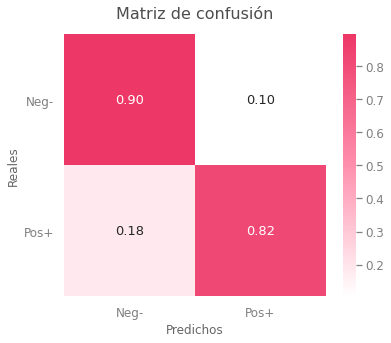

In [49]:
y_pred_prob = model.predict(X_te)
y_test_pred_lstm = np.where(y_pred_prob>0.5, 1, 0)

plt.figure(figsize=(6, 5))
conf_sent = confusion_matrix(y_test, y_test_pred_lstm, 
                             labels=[0, 1], 
                             normalize='true')
sns.heatmap(data = conf_sent, cbar=True, square=True, annot=True, 
            fmt= '.2f', annot_kws={'size': 13}, 
            xticklabels= ['Neg-', 'Pos+'], 
            yticklabels=['Neg-', 'Pos+'], 
            cmap=redpink)

plt.title('Matriz de confusión', pad=16)
plt.ylabel('Reales')
plt.xlabel('Predichos')
plt.xticks(rotation = 0)
plt.yticks(rotation = 0)
plt.tight_layout()
plt.show()

## 3. Resultados y conclusiones
![](https://i.imgur.com/cCqG6yW.png)

Como se puede observar en los resultados de la red neuronal, la diferencia frente al modelo de Linerar SVC es mínima. 

La red neuronal de LSTM produjo una mejora de 0.002 en el set de entrenamiento y de casi 0 en el set de validación. La red neuronal desmejora un poco el accuracuracy en las reviews negativas, mientras al mismo tiempo mejora un poco en las positivas. Se podría decir que predice en general predice ligeramente mejor las clases, pero la diferencia es tan baja que facilmente podría cambiarse ajustando hiperparametros en ambos modelos.

En definitiva, se rechaza la hipotesis planteada al inicio del proyecto. Utilizar una red neuronal LSTM no mejora el accuracy frente a un algoritmo de SVM con función lineal.

Hay que señalar que en ambos se controló muy bien el sobrejauste a los datos puesto que el accuracy en train y test no difiere mucho. Y es por ello que ambos modelos son opciones viables para resolver el problema, pero la opinión del autor es que el modelo de Linear SVC tiene cierta superioridad por su simpleza e interpretabilidad.

Aunque, hay que aclarar que la red neuronal aún tiene capacidad de mejora: se pueden probar modelos prenetrenados, hacer una exploración de hiperparametros más exhaustaiva o utilizar embeddings entrenados con corpus en español.
